In [2]:
!pip install xgboost 


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier

In [164]:
data = pd.read_csv("iris.csv")


In [165]:
display(data.head())

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [166]:
X = data.drop(["species"], axis=1)
y = data["species"]

In [167]:
le = LabelEncoder()
y = le.fit_transform(y)

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [169]:
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)

In [170]:
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

In [171]:
xgb = XGBClassifier(n_estimators=100, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [172]:
voting_hard = VotingClassifier(estimators=[('ada', ada), ('gb', gb), ('xgb', xgb)], voting='hard')
voting_hard.fit(X_train, y_train)
y_pred_vh = voting_hard.predict(X_test)

In [173]:
voting_soft = VotingClassifier(estimators=[('ada', ada), ('gb', gb), ('xgb', xgb)], voting='soft')
voting_soft.fit(X_train, y_train)
y_pred_vs = voting_soft.predict(X_test)


In [174]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n=== {name} Performance ===")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 3))
    print(classification_report(y_true, y_pred, target_names=le.classes_))
    return accuracy_score(y_true, y_pred)

In [175]:
results = {}
results["AdaBoost"] = evaluate_model("AdaBoost", y_test, y_pred_ada)
results["Gradient Boosting"] = evaluate_model("Gradient Boosting", y_test, y_pred_gb)
results["XGBoost"] = evaluate_model("XGBoost", y_test, y_pred_xgb)
results["Voting (Hard)"] = evaluate_model("Voting Classifier (Hard)", y_test, y_pred_vh)
results["Voting (Soft)"] = evaluate_model("Voting Classifier (Soft)", y_test, y_pred_vs)



=== AdaBoost Performance ===
Accuracy: 0.933
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.89      0.89      0.89         9
   virginica       0.91      0.91      0.91        11

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


=== Gradient Boosting Performance ===
Accuracy: 1.0
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


=== XGBoost Performance ===
Accuracy: 1.0
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.

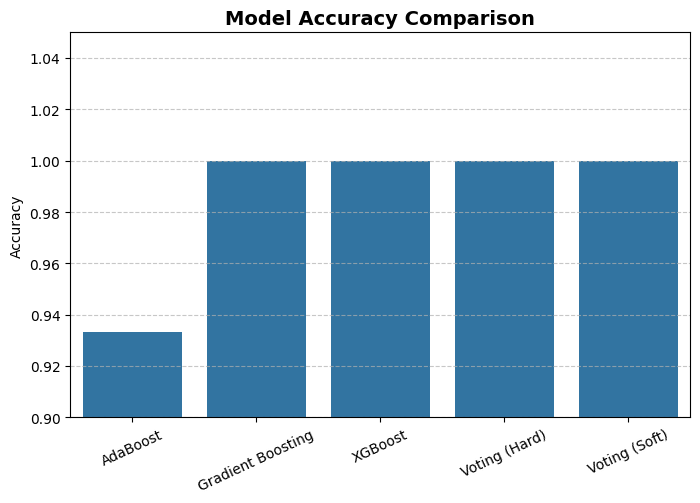

In [176]:
plt.figure(figsize=(8,5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Model Accuracy Comparison", fontsize=14, weight='bold')
plt.ylabel("Accuracy")
plt.xticks(rotation=25)
plt.ylim(0.9, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

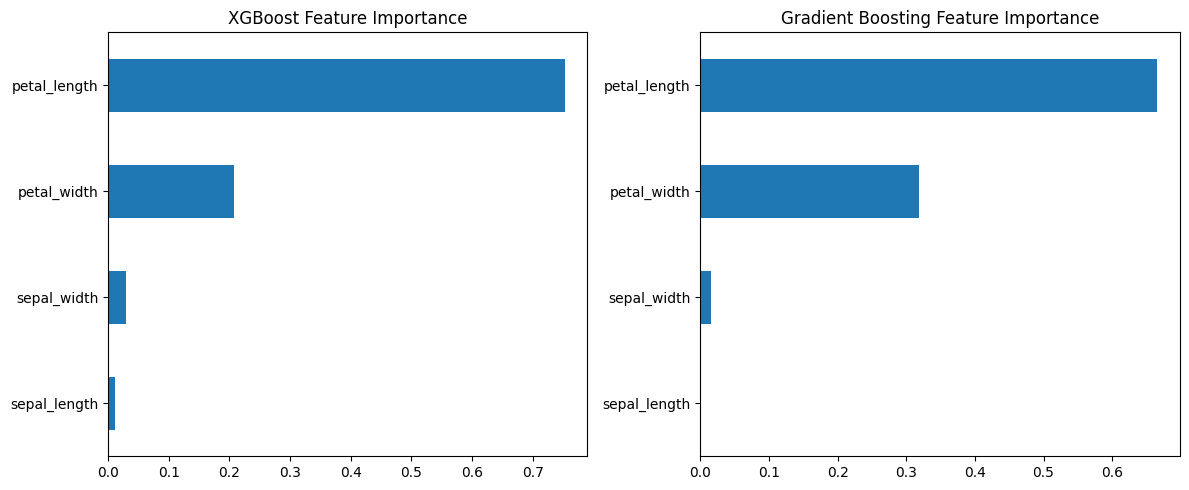

In [177]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
xgb_importances = pd.Series(xgb.feature_importances_, index=X.columns)
gb_importances = pd.Series(gb.feature_importances_, index=X.columns)

xgb_importances.sort_values().plot(kind='barh', ax=axes[0], title="XGBoost Feature Importance")
gb_importances.sort_values().plot(kind='barh', ax=axes[1], title="Gradient Boosting Feature Importance")

plt.tight_layout()
plt.show()


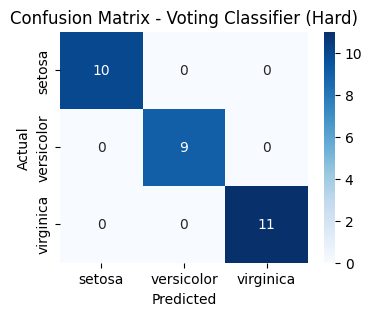

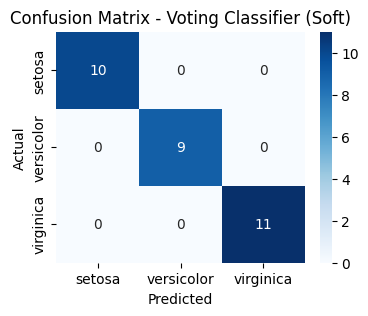

In [178]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(y_test, y_pred_vh, "Voting Classifier (Hard)")
plot_confusion_matrix(y_test, y_pred_vs, "Voting Classifier (Soft)")

In [179]:
results_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
print("\n=== Model Comparison Table ===")
display(results_df)


=== Model Comparison Table ===


,Model,Accuracy
0,AdaBoost,0.933333
1,Gradient Boosting,1.000000
2,XGBoost,1.000000
3,Voting (Hard),1.000000
4,Voting (Soft),1.000000
